# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random


# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


Note: the whole running time except the five hyperparameters tunning parts is about 130-140s.

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# use Pandas to load original training, development, and test datasets from 'csv' file.

train_ori = pd.read_csv('data_sentiment/train.csv', header = None)
dev_ori = pd.read_csv('data_sentiment/dev.csv', header = None)
test_ori = pd.read_csv('data_sentiment/test.csv', header = None)

If you use Pandas you can see a sample of the data.

In [3]:
# check the loaded data

print('check first five samples from training dataset')
print(train_ori.iloc[0:5])
print('\n')

print('check first five samples from development dataset')
print(dev_ori.iloc[0:5])
print('\n')

print('check first five samples from test dataset')
print(test_ori.iloc[0:5])
print('\n')


check first five samples from training dataset
                                                   0  1
0  note : some may consider portions of the follo...  1
1  note : some may consider portions of the follo...  1
2  every once in a while you see a film that is s...  1
3  when i was growing up in 1970s , boys in my sc...  1
4  the muppet movie is the first , and the best m...  1


check first five samples from development dataset
                                                   0  1
0  if he doesn=92t watch out , mel gibson is in d...  1
1  wong kar-wei's " fallen angels " is , on a pur...  1
2  there is nothing like american history x in th...  1
3  an unhappy italian housewife , a lonely waiter...  1
4  when people are talking about good old times ,...  1


check first five samples from test dataset
                                                   0  1
0  wild things is a suspenseful thriller starring...  1
1  i know it already opened in december , but i f...  1
2  what's shocki

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
# put the raw texts into list and corresponding labels into NumPy arrays

train_text = [train_ori.iloc[i, 0] for i in range(train_ori.shape[0])]
train_label = np.array([train_ori.iloc[i, 1] for i in range(train_ori.shape[0])]) # train_label's shape is (1400, )

dev_text = [dev_ori.iloc[i, 0] for i in range(dev_ori.shape[0])]
dev_label = np.array([dev_ori.iloc[i, 1] for i in range(dev_ori.shape[0])]) # dev_label's shape is (200, )

test_text = [test_ori.iloc[i, 0] for i in range(test_ori.shape[0])]
test_label = np.array([test_ori.iloc[i, 1] for i in range(test_ori.shape[0])]) # test_label's shape is (400, )

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [5]:
# I add 'am', 'll', 'also', 'why', 'would', 'should', 'their', 'might', 'there', 'where', 'him' to the 
# stop_words list, because these words are not useful to sentiment classification task.

stop_words = ['a','am','in','ll','on','at','and','or', "also", "why", "would", "should", "their", "might",
              'to', 'the', 'of', 'an', 'by', "there", "where", "him",
              'as', 'is', 'was', 'were', 'been', 'be',
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'', 
                   stop_words=[], vocab=set(), char_ngrams=False):
    """
        We are going to convert the tokens to lowercase, removes the stopwords and punctuations before 
        generating bigrams or trigrams.
    """
    # The original texts has been converted to lowercase
    
    # remove all punctuations, remove all numbers
    # find those words containing two or more than two letters, remove simple words such as "a", "I"...
    # drop all numbers
    # list_word = re.split(r'[^\w]+', x_raw) 
    
    list_word = re.findall(r"(?u)\b\w\w+\b", x_raw) 
        
    # Remove the stopwords
    for word in stop_words:
        occ = list_word.count(word)
        for i in range(occ):
            list_word.remove(word)
    
    #     Get the n_grams features for x_raw based on flag char_ngrams, if char_ngrams is False, then pick up words 
    # features. If char_ngrams is True, then pick up characters features.
    
    if char_ngrams == False:
        list_ngrams = [] # initialize the list of ngrams
        
        # obtain unigrams, bigrams, or trigrams according to argument - 'ngram_range'.
        for i in range(ngram_range[0], ngram_range[1] + 1):
            if i == 1: # get the list of unigrams for x_raw
                list_unigrams = list_word
                list_ngrams += list_unigrams
            elif i == 2:
                list_bigrams = []
                for j in range(len(list_word) - 1):
                    list_bigrams.append(list_word[j] + ' ' + list_word[j + 1])
                    
                list_ngrams += list_bigrams
            else:
                list_trigrams = []
                for j in range(len(list_word) - 2):
                    list_trigrams.append(list_word[j] + ' ' + list_word[j + 1] 
                                         + ' ' + list_word[j + 2])
                
                list_ngrams += list_trigrams
    
        list_extracted_feature = list_ngrams
    
    # Get the char_n_grams features
    
    else:
        list_char_ngrams = [] # initialize the list of character ngrams
        whole_string = "".join(list_word)
        
        # obtain char-unigrams, char-bigrams, or char-bigrams according to argument - 
        # 'ngram_range'
        for i in range(ngram_range[0], ngram_range[1] + 1):
            list_char_temp = []
            for j in range(len(whole_string) - i + 1):
                list_char_temp.append(whole_string[j:j+i])
            list_char_ngrams += list_char_temp
        
        list_extracted_feature = list_char_ngrams
    
    # Get specific features if 'vocab' argument is given
    
    if len(vocab) != 0:
        list_specific_feature = []
        for feature in list_extracted_feature:
            if feature in vocab:
                list_specific_feature.append(feature)
        
        list_extracted_feature = list_specific_feature
        
    
    return list_extracted_feature




Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [7]:
# Test the extract_ngrams function.
extract_ngrams('Song yang Li', 
               ngram_range=(3, 6), 
               stop_words=stop_words,
               char_ngrams=True)

['Son',
 'ong',
 'ngy',
 'gya',
 'yan',
 'ang',
 'ngL',
 'gLi',
 'Song',
 'ongy',
 'ngya',
 'gyan',
 'yang',
 'angL',
 'ngLi',
 'Songy',
 'ongya',
 'ngyan',
 'gyang',
 'yangL',
 'angLi',
 'Songya',
 'ongyan',
 'ngyang',
 'gyangL',
 'yangLi']

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [8]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'', 
              min_df=0, keep_topN=None, 
              stop_words=[],char_ngrams=False):
    
    # initialize a set to contain ngrams that will be used as features
    vocab = set()
    
    # initialize the dictionary to contain ngrams as keys and their corresponding document
    # frequency as values
    df = dict()
    
    # initialize the dictionary to contain ngrams as keys and their corresponding counts in
    # vocab as values
    ngram_counts = dict()
    
    # extract features for each documents in X_raw
    for x_raw in X_raw:
        extracted_feature = extract_ngrams(x_raw = x_raw, ngram_range = ngram_range, 
                                          stop_words = stop_words, char_ngrams = char_ngrams)
        
        # get the dictionary for term frequency
        for feature in extracted_feature:
            if feature not in ngram_counts:
                ngram_counts[feature] = 1
            else:
                ngram_counts[feature] += 1
        
        # get the dictionary for document frequency
        for feature in set(extracted_feature):
            if feature not in df:
                df[feature] = 1
            else:
                df[feature] += 1
                
                
    
    """
            When build the vocabulary, we need to consider two arguments "keep_topN" and "min_df".
            If "keep_topN" is None, then we only need to consider the condition of "min_df". We will ignore those 
        words with document frequencies lower than "min_df".
            However, it "keep_topN" is not None but an integer. Then we should also consider the value of "min_df".
        In this case, we will keep top "keep_topN" words based on their frequencies in the whole collection, 
        and meanwhile, these words' document frequencies should be higher than "min_df".
    """
    if keep_topN == None:
        if min_df == 0:
            for feature in df:
                vocab.add(feature)
        else:
            for feature in df:
                if df[feature] >= min_df:
                    vocab.add(feature)
    else:
        # sort the ngrams based on their corresponding counts, from greater to lower.
        sorted_ngram_counts = dict(sorted(ngram_counts.items(),
                                         key = lambda item: item[1], reverse = True))
        sorted_ngram_counts = list(sorted_ngram_counts.keys())
        
        if min_df == 0:
            for i in range(keep_topN):
                vocab.add(sorted_ngram_counts[i])
        else:
            i = 0
            while(len(vocab) < keep_topN):
                if df[sorted_ngram_counts[i]] >= min_df:
                    vocab.add(sorted_ngram_counts[i])
                i += 1
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [9]:
# create a vocabulary, and get document and raw frequencies of n-grams.
# set I need unigrams, bigrams, and trigrams with a document frequencies higher than 20

vocab_bow, df_bow, ngram_counts_bow = get_vocab(X_raw = train_text, ngram_range = (1, 3), min_df = 20, 
                                    stop_words = stop_words, char_ngrams = False)


Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [10]:
#     create 2 dictionaries: (1) id2word_bow: keys = vocabulary ids, values = words (2) word2id_bow: keys = words, 
# values = vocabulary ids

id2word_bow = dict()
word2id_bow = dict()

for i in range(len(vocab_bow)):
    id2word_bow[i] = list(vocab_bow)[i]
    word2id_bow[list(vocab_bow)[i]] = i

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [11]:
# initialize three list for training texts, development texts, and test texts
train_extracted_ngrams = []
dev_extracted_ngrams = []
test_extracted_ngrams = []

# extract ngrams for training set
for i in range(len(train_text)):
    temp = extract_ngrams(x_raw = train_text[i], ngram_range = (1, 3), 
                          stop_words = stop_words, char_ngrams = False)
    train_extracted_ngrams.append(temp)

# extract ngrams for development set
for i in range(len(dev_text)):
    temp = extract_ngrams(x_raw = dev_text[i], ngram_range = (1, 3),
                         stop_words = stop_words, char_ngrams = False)
    dev_extracted_ngrams.append(temp)

# extract ngrams for test set
for i in range(len(test_text)):
    temp = extract_ngrams(x_raw = test_text[i], ngram_range = (1, 3),
                         stop_words = stop_words, char_ngrams = False)
    test_extracted_ngrams.append(temp)
    

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [12]:
# This function could vectorise word/char features of training documents to a feature value matrix.
def vectorise(X_ngram, vocab, word2id):
    # initialize a N x |vocab| array for X_vec
    X_vec = np.zeros((len(X_ngram), len(vocab)))
    
    row = 0
    for doc in X_ngram:
        for ngram in doc:
            if ngram in vocab:
                X_vec[row, word2id[ngram]] += 1
        
        row += 1
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [13]:
# obtain count vectors for each document in the train, developemnt and test set
train_count_mat = vectorise(train_extracted_ngrams, vocab_bow, word2id_bow)
dev_count_mat = vectorise(dev_extracted_ngrams, vocab_bow, word2id_bow)
test_count_mat = vectorise(test_extracted_ngrams, vocab_bow, word2id_bow)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [14]:
# compute the inverted document frequencies values for words in vocab
idfs_bow = np.zeros((1, len(vocab_bow)))

for i in range(len(vocab_bow)):
    idfs_bow[0, i] = np.log10(len(train_text)/df_bow[list(vocab_bow)[i]])

Then transform your count vectors to tf.idf vectors:

In [15]:
# transform the count vectors to tf.idf vectors

train_tfidf_mat = train_count_mat * idfs_bow
dev_tfidf_mat = dev_count_mat * idfs_bow
test_tfidf_mat = test_count_mat * idfs_bow

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [16]:
def sigmoid(z):
    # sigmoid of z
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [17]:
# function predict_proba will return a array with size N*1, where N is the documents number of input data.

def predict_proba(X, weights):
    
    # weights should be reshaped to |vocab|*1 size
    
    weights = weights.reshape(-1, 1)
    
    
    weighted_input = X @ weights
    
    preds_proba = sigmoid(weighted_input)
    
    
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [18]:
def predict_class(X, weights):
    
    preds_proba = predict_proba(X, weights) # a N*1 shape array
    
    for row in range(preds_proba.shape[0]):
        if (preds_proba[row, 0] >= 0.5):
            preds_proba[row, 0] = 1
        else:
            preds_proba[row, 0] = 0
    
    preds_class = preds_proba
    
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [19]:
def binary_loss(X, Y, weights, alpha=0.00001):
    '''
    Binary Cross-entropy Loss

    X:(len(X),len(vocab))
    Y: array len(Y)
    weights: array len(X)
    '''
    
    # initialize the loss
    l = 0
    
    # compute the binary entropy loss for all documents in X
    
    pred_proba = predict_proba(X, weights)
    
    # l = -Y*(log(P)) - (1 - Y)*log(1 - P) + regularization term
    
    l = -Y.reshape(1, -1) @ np.log(1e-15 + pred_proba) - \
        (1 - Y.reshape(1, -1)) @ np.log(1e-15 + 1 - pred_proba) + \
        1/2*alpha*(weights.reshape(1, -1) @ weights.reshape(-1, 1))
    
    l = l/X.shape[0]

    return l
    



Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [20]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, 
        alpha=0.00001, epochs=5, 
        tolerance=0.0001, print_progress=True):
    
        
    # initialize the weights
    weights = np.zeros((X_tr.shape[1], 1)) # size: |vocab|*1
    
    # merge the features and labels of training set and dev set into lists by zip(), it will be useful to 
    # randomize their orders before each epoch
    
    tr = list(zip(X_tr, Y_tr))
    
    # initialize training_loss_history and validation_loss_history
    training_loss_history = []
    training_loss_history.append(binary_loss(X_tr, Y_tr, weights, alpha = alpha)[0, 0])
    validation_loss_history = []
    validation_loss_history.append(binary_loss(X_dev, Y_dev, weights, alpha = alpha)[0, 0])
    
    
    for epoch in range(epochs):
        # randomise the training set at the beginning of each epoch
        random.shuffle(tr)
        
        for x, y in tr:
            # update the weights by following equation
            """
            new_weights = old_weights - (learning rate) * (((p - y) * x) + (regularization term))  
            """
            
            weights = weights - lr*(((predict_proba(x, weights) - y)*x).reshape(-1, 1) + alpha*weights)
            
        
        # update the training and validation loss by using updated weights
        training_loss_history.append(binary_loss(X_tr, Y_tr, weights, alpha = alpha)[0, 0])
        validation_loss_history.append(binary_loss(X_dev, Y_dev, weights, alpha = alpha)[0, 0])
        
        # print the training and validation loss if print_progress flag is True
        if print_progress == True:
            print("epoch {:3d}: training loss is {:.6f}, validation loss is {:.6f}."\
                  .format(epoch, 
                          training_loss_history[epoch + 1], 
                          validation_loss_history[epoch + 1]))
        
        # I use the absolute value of difference between previous validation loss and current validation loss.
        # Because there might be slight rise and fall in validation loss in training period, but the overall tendency
        # of validation loss is still falling.
        
        if abs(validation_loss_history[epoch] - validation_loss_history[epoch + 1]) <= tolerance:
            break
        
            
    
    
    

    return weights, training_loss_history, validation_loss_history

# Model 1: BOW-COUNT

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

Define a function to choose the best hyperparameters.

In [21]:
# By comparing the validation loss under different hyperparameter combinations, we could choose the best 
# hyperparameters with the lowest validation loss.

# I choose to define a function to choose the hyperparameters

def choose_hyper(X_tr, Y_tr, X_dev, Y_dev, lr_candidate = [], alpha_candidate = [], epoch_candidate = [], 
                 tolerance_candidate = []):
    
    """
    The arguments lr_candidate, alpha_candidate, epoch_candidate, and tolerance_candidate are the candidates for 
    the best hyperparameters.
    """
    
    
    # initialize a validation loss
    current_val_loss = 100000
    
    # compute different validation loss and validation accuracy under different hyperparameter combinations
    
    for lr in lr_candidate:
        for alpha in alpha_candidate:
            for epoch in epoch_candidate:
                for tolerance in tolerance_candidate:
                    weights, tr_loss, val_loss = SGD(X_tr, Y_tr, X_dev, Y_dev, lr = lr, alpha = alpha, 
                                                     epochs = epoch, tolerance = tolerance, print_progress = False)
                    
                    print("lr = {:.6f}, alpha = {:.6f}, epoch = {:3d}, tolerance = {:.6f}, val_loss = {:.6f}, val_acc = {:.6f}"\
                         .format(lr, alpha, epoch, tolerance, val_loss[-1], 
                                 accuracy_score(Y_dev, predict_class(X_dev, weights))))
                    
                    print("")
                    
                    if val_loss[-1] < current_val_loss:
                        current_val_loss = val_loss[-1]
                        best_lr = lr
                        best_alpha = alpha
                        best_epoch = epoch
                        best_tolerance = tolerance
    
    
    # return the best hyperparameters which could reach the best validation loss
    best_parameter = [best_lr, best_alpha, best_epoch, best_tolerance]
    
    print("The best parameters are: lr = {}, alpha = {}, epoch = {}, tolerance = {}".format(best_parameter[0], 
                                                                                           best_parameter[1],
                                                                                           best_parameter[2],
                                                                                           best_parameter[3]))
    

    
    return best_parameter
                    


## Hyperparameters tuning for BOW-COUNT model. 

This part is not counted in time for grading.

Choose the best hyperparameters with the lowest validation loss.

In [22]:
# hyperparameter tuning
# choose best hyperparameters by using defined function "choose_hyper()" for BOW-count features
best_parameter_bow_c = choose_hyper(train_count_mat, train_label, dev_count_mat, dev_label, 
                              lr_candidate = [1e-6, 1e-5], alpha_candidate = [5*1e-1, 1e-1], 
                              epoch_candidate = [100, 300], tolerance_candidate = [1e-4, 1e-5])

lr = 0.000001, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.650078, val_acc = 0.730000

lr = 0.000001, alpha = 0.500000, epoch = 100, tolerance = 0.000010, val_loss = 0.650074, val_acc = 0.730000

lr = 0.000001, alpha = 0.500000, epoch = 300, tolerance = 0.000100, val_loss = 0.603438, val_acc = 0.740000

lr = 0.000001, alpha = 0.500000, epoch = 300, tolerance = 0.000010, val_loss = 0.603436, val_acc = 0.740000

lr = 0.000001, alpha = 0.100000, epoch = 100, tolerance = 0.000100, val_loss = 0.649038, val_acc = 0.730000

lr = 0.000001, alpha = 0.100000, epoch = 100, tolerance = 0.000010, val_loss = 0.649039, val_acc = 0.730000

lr = 0.000001, alpha = 0.100000, epoch = 300, tolerance = 0.000100, val_loss = 0.597890, val_acc = 0.745000

lr = 0.000001, alpha = 0.100000, epoch = 300, tolerance = 0.000010, val_loss = 0.597890, val_acc = 0.745000

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.543962, val_acc = 0.785000

lr = 0.000010, alph

Hyperparameters tuning for BOW-COUNT model end.

## Train the model for BOW-COUNT by using the best hyperparameters.

In [23]:
# after choosing the best parameters, we could use these parameters to train the model for BOW-count features.

weights_bow_c, tra_loss_bow_c, val_loss_bow_c = SGD(train_count_mat, train_label, dev_count_mat, dev_label,
                                                    lr = best_parameter_bow_c[0], 
                                                    alpha = best_parameter_bow_c[1],
                                                    epochs = best_parameter_bow_c[2],
                                                    tolerance = best_parameter_bow_c[3], print_progress = True)

epoch   0: training loss is 0.685818, validation loss is 0.687152.
epoch   1: training loss is 0.679100, validation loss is 0.682006.
epoch   2: training loss is 0.672717, validation loss is 0.677050.
epoch   3: training loss is 0.666615, validation loss is 0.672550.
epoch   4: training loss is 0.660792, validation loss is 0.668108.
epoch   5: training loss is 0.655204, validation loss is 0.663948.
epoch   6: training loss is 0.649844, validation loss is 0.659996.
epoch   7: training loss is 0.644704, validation loss is 0.656128.
epoch   8: training loss is 0.639744, validation loss is 0.652579.
epoch   9: training loss is 0.634983, validation loss is 0.649160.
epoch  10: training loss is 0.630359, validation loss is 0.645664.
epoch  11: training loss is 0.625901, validation loss is 0.642309.
epoch  12: training loss is 0.621592, validation loss is 0.639138.
epoch  13: training loss is 0.617424, validation loss is 0.636024.
epoch  14: training loss is 0.613396, validation loss is 0.633

epoch 123: training loss is 0.426511, validation loss is 0.506548.
epoch 124: training loss is 0.425683, validation loss is 0.506008.
epoch 125: training loss is 0.424865, validation loss is 0.505521.
epoch 126: training loss is 0.424051, validation loss is 0.505000.
epoch 127: training loss is 0.423249, validation loss is 0.504543.
epoch 128: training loss is 0.422446, validation loss is 0.504006.
epoch 129: training loss is 0.421656, validation loss is 0.503544.
epoch 130: training loss is 0.420867, validation loss is 0.503015.
epoch 131: training loss is 0.420087, validation loss is 0.502545.
epoch 132: training loss is 0.419313, validation loss is 0.502024.
epoch 133: training loss is 0.418550, validation loss is 0.501496.
epoch 134: training loss is 0.417785, validation loss is 0.501060.
epoch 135: training loss is 0.417033, validation loss is 0.500564.
epoch 136: training loss is 0.416280, validation loss is 0.500162.
epoch 137: training loss is 0.415537, validation loss is 0.499

epoch 246: training loss is 0.358456, validation loss is 0.466087.
epoch 247: training loss is 0.358084, validation loss is 0.465890.
epoch 248: training loss is 0.357715, validation loss is 0.465693.
epoch 249: training loss is 0.357345, validation loss is 0.465452.
epoch 250: training loss is 0.356981, validation loss is 0.465285.
epoch 251: training loss is 0.356615, validation loss is 0.465045.
epoch 252: training loss is 0.356253, validation loss is 0.464824.
epoch 253: training loss is 0.355892, validation loss is 0.464620.
epoch 254: training loss is 0.355534, validation loss is 0.464411.
epoch 255: training loss is 0.355177, validation loss is 0.464225.
epoch 256: training loss is 0.354822, validation loss is 0.464047.
epoch 257: training loss is 0.354470, validation loss is 0.463878.
epoch 258: training loss is 0.354119, validation loss is 0.463681.
epoch 259: training loss is 0.353768, validation loss is 0.463457.
epoch 260: training loss is 0.353420, validation loss is 0.463

### Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

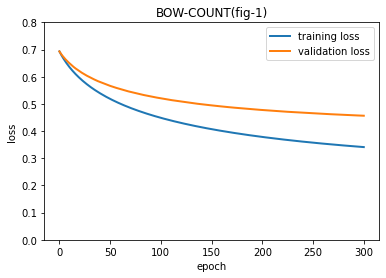

In [24]:
# define a function to plot the training and validation history 

def plot_loss_history(tra_loss_history, val_loss_history, mode):
    
    x_value = np.array([i for i in range(len(tra_loss_history))])
    
    plt.plot(x_value,tra_loss_history, lw = 2, label = "training loss")
    plt.plot(x_value, val_loss_history, lw = 2, label = "validation loss")
    
    
    plt.title(mode)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim([0, 0.8])
    plt.legend()


plot_loss_history(tra_loss_bow_c, val_loss_bow_c, "BOW-COUNT(fig-1)")

Explain here...

Because we have five models, we will analyze this question after the "loss-epoch" figure for each model.

From the figure 1, we could find our mode is trained well. 

1. The validation loss line is small (about 0.45) and is becoming flat at the end of training. Besides, the test accuracy of the following evaluation part is high (about 83.25%). Therefore the model is not underfitted.
2. Because the validation loss line doesn't tend to rise and is still in the process from declining to flatting, and the difference between the final training loss and the final validation loss is small enough (about 0.12), the model is not overfitted.



#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [25]:
preds_bow_c = predict_class(test_count_mat, weights_bow_c)

print('Accuracy:', accuracy_score(test_label, preds_bow_c))
print('Precision:', precision_score(test_label, preds_bow_c))
print('Recall:', recall_score(test_label, preds_bow_c))
print('F1-Score:', f1_score(test_label, preds_bow_c))

Accuracy: 0.8225
Precision: 0.8056872037914692
Recall: 0.85
F1-Score: 0.8272506082725061


Finally, print the top-10 words for the negative and positive class respectively.

In [26]:
top_neg = weights_bow_c.reshape(1, -1).argsort()[0][:10]
for i in top_neg:
    print(id2word_bow[i])

bad
only
plot
even
no
any
worst
script
nothing
unfortunately


In [27]:
top_pos = weights_bow_c.reshape(1, -1).argsort()[0][::-1][:10]
for i in top_pos:
    print(id2word_bow[i])

great
well
life
world
many
best
seen
both
very
most


### If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

Because we have five models, we will analyze this question for each model after its own top-10 words/chars.

From the observation on these return words, I think half of them make sense. For example, in the top-10 negative words, we could see the negative words like "bad", "worst", "nothing", "unfortunately" and, in the top-10 positive words, we could see the positive words like "great", "well", "best", "very".

I think these aforementioned words, such as "bad", "great", "best", "well", and, "worst", could generalize well in other domains like a restaurant reviews or laptop reviews. Because these words could express the opinions of customers to any kinds of merchandises and services. However, there are also some words like "plot" and "script" not generalizing well. Because these two words are only common in movies' area.

The classifier should use the following words to express the emotions of customers or to express the opinions of customers to the merchandises for generalization. For example, the words "happy", "surprised", "sad", and "disappointed" could be used to express the emotions of customers in every domain and the words "great", "worthy", "expensive", and "bad" could be used in every domain because they could express the opinions of customers to most kind of merchandises or services.

For the restaurant reviews domain, the classifier may pick up words like "delicious", "tasty", "smelly", "expensive", "cold", "fresh".... and for laptop review domain, the classifier may pick up words like "light", "beautiful", "fast"...

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...

We have five models, so I will answer this question for each model.

1. I choose the hyperparameters (learning rate, alpha, epoch, tolerance) by testing the development(validation) dataset on several different set of hyperparameters. The set of hyperparameters which could help the model to achieve the highest validation accuracy and lowest validation loss are the best hyperparameters. I will randomly display several set of hyperparameters and the corresponding validation loss and validation accuracy.

| lr | alpha |epoch  | tolerance | val_loss | val_accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 0.000010  | 0.100000 | 300  |  0.000100 | 0.456529  | 0.825000  |
| 0.000010  |  0.500000| 300  |  0.000100  | 0.526353 | 0.810000  |
| 0.000010  | 0.100000   |100  | 0.000100 | 0.520493  | 0.800000  |
| 0.000001 | 0.100000  |  300  | 0.000100  | 0.597890  | 0.745000  |
| 0.000010  | 0.100000   |  300 | 0.000010  |0.456530  | 0.825000 |

From the above table, we could find when the lr = 1e-5, alpha = 0.1, epoch = 300, tolerance = 1e-4, the model has lowest validation loss (0.456) and highest validation accuracy (0.825). Therefore, I choose this set of hyperparameter as my best hyperparameter for model of BOW-COUNT.

2. From the above table and training process, I find if the learning rate is small, then the model need lost of epochs to complete the training to achieve a high validation accuracy. If the learning rate is large, the model will only need a few epoch to complete the training.


3. From the above table, we could know the regularization strength could help the model not be overtrained. It means, if we use a large regularization strength (alpha), then the training loss will decrease more slowly than using a small regularization strength. If we don't add a regularization term or use a small regularization strength, the model might be overfitted.



## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


## Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning process for each model...

# Model 2: BOW-TFIDF

## Training and evaluation for BOW-tfidf

Because we have get the vectorized features matrices for BOW-tfidf, we could us them directly.

Please don't count the hyperparameters tunning time for grading.

In [28]:
# choose best hyperparameters for BOW-tfidf

best_parameter_bow_tfidf = choose_hyper(train_tfidf_mat, train_label, dev_tfidf_mat, dev_label, 
                              lr_candidate = [1e-6, 1e-5], alpha_candidate = [5*1e-1, 1e-1], 
                              epoch_candidate = [100, 300], tolerance_candidate = [1e-4, 1e-5])

lr = 0.000001, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.669359, val_acc = 0.695000

lr = 0.000001, alpha = 0.500000, epoch = 100, tolerance = 0.000010, val_loss = 0.669358, val_acc = 0.695000

lr = 0.000001, alpha = 0.500000, epoch = 300, tolerance = 0.000100, val_loss = 0.636845, val_acc = 0.760000

lr = 0.000001, alpha = 0.500000, epoch = 300, tolerance = 0.000010, val_loss = 0.636845, val_acc = 0.760000

lr = 0.000001, alpha = 0.100000, epoch = 100, tolerance = 0.000100, val_loss = 0.668735, val_acc = 0.700000

lr = 0.000001, alpha = 0.100000, epoch = 100, tolerance = 0.000010, val_loss = 0.668735, val_acc = 0.700000

lr = 0.000001, alpha = 0.100000, epoch = 300, tolerance = 0.000100, val_loss = 0.632733, val_acc = 0.760000

lr = 0.000001, alpha = 0.100000, epoch = 300, tolerance = 0.000010, val_loss = 0.632733, val_acc = 0.760000

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.583639, val_acc = 0.780000

lr = 0.000010, alph

End of hyperparameters tunning.

## Train the model of BOW-TFIDF by using the best hyperparameters.

In [29]:
# Under BOW-tfidf situation, training the model by using the best parameters
weights_bow_tfidf, tra_loss_bow_tfidf, val_loss_bow_tfidf = SGD(train_tfidf_mat, train_label, dev_tfidf_mat, 
                                                                dev_label, 
                                                                lr = best_parameter_bow_tfidf[0], 
                                                                alpha = best_parameter_bow_tfidf[1],
                                                                epochs = best_parameter_bow_tfidf[2],
                                                                tolerance = best_parameter_bow_tfidf[3], 
                                                                print_progress = True)

epoch   0: training loss is 0.688411, validation loss is 0.690324.
epoch   1: training loss is 0.683823, validation loss is 0.687615.
epoch   2: training loss is 0.679373, validation loss is 0.685008.
epoch   3: training loss is 0.675039, validation loss is 0.682484.
epoch   4: training loss is 0.670819, validation loss is 0.680043.
epoch   5: training loss is 0.666696, validation loss is 0.677668.
epoch   6: training loss is 0.662661, validation loss is 0.675347.
epoch   7: training loss is 0.658714, validation loss is 0.673084.
epoch   8: training loss is 0.654847, validation loss is 0.670872.
epoch   9: training loss is 0.651058, validation loss is 0.668713.
epoch  10: training loss is 0.647342, validation loss is 0.666596.
epoch  11: training loss is 0.643694, validation loss is 0.664522.
epoch  12: training loss is 0.640115, validation loss is 0.662493.
epoch  13: training loss is 0.636598, validation loss is 0.660495.
epoch  14: training loss is 0.633143, validation loss is 0.658

epoch 123: training loss is 0.436389, validation loss is 0.546946.
epoch 124: training loss is 0.435411, validation loss is 0.546397.
epoch 125: training loss is 0.434441, validation loss is 0.545854.
epoch 126: training loss is 0.433479, validation loss is 0.545314.
epoch 127: training loss is 0.432525, validation loss is 0.544779.
epoch 128: training loss is 0.431578, validation loss is 0.544248.
epoch 129: training loss is 0.430638, validation loss is 0.543721.
epoch 130: training loss is 0.429706, validation loss is 0.543200.
epoch 131: training loss is 0.428780, validation loss is 0.542682.
epoch 132: training loss is 0.427862, validation loss is 0.542167.
epoch 133: training loss is 0.426951, validation loss is 0.541657.
epoch 134: training loss is 0.426047, validation loss is 0.541151.
epoch 135: training loss is 0.425150, validation loss is 0.540649.
epoch 136: training loss is 0.424259, validation loss is 0.540149.
epoch 137: training loss is 0.423376, validation loss is 0.539

epoch 246: training loss is 0.355186, validation loss is 0.501772.
epoch 247: training loss is 0.354743, validation loss is 0.501528.
epoch 248: training loss is 0.354301, validation loss is 0.501284.
epoch 249: training loss is 0.353862, validation loss is 0.501042.
epoch 250: training loss is 0.353426, validation loss is 0.500802.
epoch 251: training loss is 0.352991, validation loss is 0.500562.
epoch 252: training loss is 0.352559, validation loss is 0.500324.
epoch 253: training loss is 0.352129, validation loss is 0.500087.
epoch 254: training loss is 0.351702, validation loss is 0.499851.
epoch 255: training loss is 0.351277, validation loss is 0.499617.
epoch 256: training loss is 0.350853, validation loss is 0.499384.
epoch 257: training loss is 0.350432, validation loss is 0.499152.
epoch 258: training loss is 0.350014, validation loss is 0.498921.
epoch 259: training loss is 0.349597, validation loss is 0.498692.
epoch 260: training loss is 0.349183, validation loss is 0.498

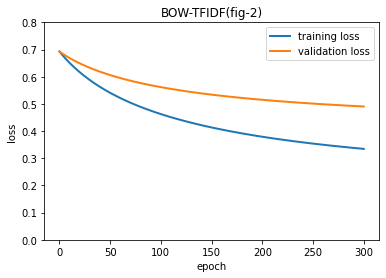

In [30]:
# plot the figure to check the training and validation loss during the training process

plot_loss_history(tra_loss_bow_tfidf, val_loss_bow_tfidf, "BOW-TFIDF(fig-2)")

### Analyze the loss-epoch figure for model of BOW-TFIDF

Through observing the figure 2, we could determine that the model for BOW-TFIDF is trained well.

1. The validation loss is low (about 0.488), the validation loss line begins to be flat at the end of training, and the test accuracy from the following evaluation is high (about 85.5%). Therefore, the model is not underfitted.

2. The difference between the final validation loss and final training loss on the figure 2 is small (about 0.15) and the validation loss line doesn't have the tend to rise. Therefore, the model is not overfitted.

In [31]:
# compute the accuracy, precision, recall, and f1_score to evaluate the model under BOW-tfidf situation

preds_bow_tfidf = predict_class(test_tfidf_mat, weights_bow_tfidf)

print('Accuracy:', accuracy_score(test_label, preds_bow_tfidf))
print('Precision:', precision_score(test_label, preds_bow_tfidf))
print('Recall:', recall_score(test_label, preds_bow_tfidf))
print('F1-Score:', f1_score(test_label, preds_bow_tfidf))

Accuracy: 0.865
Precision: 0.8509615384615384
Recall: 0.885
F1-Score: 0.8676470588235293


In [32]:
# print top 10 words for negative class and positive class respectively.

top_neg_bow_tfidf = weights_bow_tfidf.reshape(1, -1).argsort()[0][:10]
for i in top_neg_bow_tfidf:
    print(id2word_bow[i])

bad
worst
boring
supposed
stupid
harry
ridiculous
unfortunately
nothing
plot


In [33]:
top_pos_bow_tfidf = weights_bow_tfidf.reshape(1, -1).argsort()[0][::-1][:10]
for i in top_pos_bow_tfidf:
    print(id2word_bow[i])

great
life
world
war
perfectly
hilarious
perfect
terrific
cameron
damon


### Analyze the top-10 words for model of BOW-TFIDF

After observing the above top-10 words, we could find the top-10 words for BOW-TFIDF model could make more sense. Almost all of them are useful to classify if a review is positive or negative.

For example, the top-10 negative words include "bad", "worst", "boring", "stupid", "ridiculous", "unfortunately", and "nothing", and the top-10 positive words include "great", "perfectly", "hilarious", "cameron", "damon", and "terrific". All of these words are useful to classify the opinion of movies' reviews.

Among them, some are generalized well and could be used in other areas, such as "bad", "worst", "great", "perfectly", and "terrific". You could describe a laptop or a food is "bad" or "great". However, some of them are not generalized well and couldn't be used in other areas such as a restaurant review. Because you could not describe the food is "ridiculous" and there is no food related to the movie director "Cameron" and actor "Damon".

We should notice that some adjective words are restricted to be used as a classification feature. Because it might be not proper to describe a food with the adjective "romantic".

### Discuss how I choose hyperparameters for model of BOW-TFIDF

1. I choose the hyperparameters (learning rate, alpha, epoch, tolerance) by testing the development(validation) dataset on several different set of hyperparameters. The set of hyperparameters which could help the model to achieve the highest validation accuracy and lowest validation loss are the best hyperparameters. I will randomly display several set of hyperparameters and the corresponding validation loss and validation accuracy.

| lr | alpha |epoch  | tolerance | val_loss | val_accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 0.000010  | 0.100000 | 300  |  0.000100 | 0.490416  | 0.835000  |
| 0.000010  |  0.500000| 300  |  0.000100  | 0.557859 | 0.795000  |
| 0.000010  | 0.100000   |100  | 0.000100 | 0.561617  | 0.800000 |
| 0.000001 | 0.100000  |  300  | 0.000100  | 0.632733  | 0.760000  |
| 0.000010  | 0.100000   |  300 | 0.000010  |0.490415  | 0.835000 |

From the above table, we could find when the lr = 1e-5, alpha = 0.1, epoch = 300, tolerance = 1e-5, the validation loss is lowest (0.49) and the validation accuracy is highest (0.835). Therefore, I choose this set of hyperparameters as my best hyperparameters for model of BOW-TFIDF.

# Model 3: BOCN-COUNT

## Training and evaluation for BOCN-COUNT
Because we don't have the vocabulary and vectorized matrix for BOCN-COUNT/TIFDF. We need to get the vocabulary and vectorized matrix first.

In [34]:
# get the vocabular, document frequency dictionary, and counts dictionary for BOCN 
#     I choose the keep_topN = 4000 because if the keep_topN is too large, there will be too many words in vocabulary 
# for BOCN. It will slow down the training speed.

#     I choose the ngram_range = (3, 5) because if the ngram_range value is too small, the character combinations 
# will be too short. At this time, different words could produce the same character combinations. For example, a
# negative word "worst" contain character combinations "wo", but a positive word "wonderful" could also contain a
# character combinations "wo". So, if the ngram_range value is too small, the short character combinations would be
# confusing.
#    Similarly, if ngram_range is too large, the character combinations would be too long. At that time, a long 
# character combination might only appear in one document. It will be also bad for model training.

vocab_bocn, df_bocn, ngram_counts_bocn = get_vocab(X_raw = train_text, ngram_range = (3, 5), min_df = 0, 
                                                   keep_topN = 4000, stop_words = stop_words, char_ngrams = True)

In [35]:
#     create 2 dictionaries: (1) id2word_bocn: keys = vocabulary ids, values = words (2) word2id_bocn: keys = words, 
# values = vocabulary ids for BOCN

id2word_bocn = dict()
word2id_bocn = dict()

for i in range(len(vocab_bocn)):
    id2word_bocn[i] = list(vocab_bocn)[i]
    word2id_bocn[list(vocab_bocn)[i]] = i

In [36]:
# initialize three list for training texts, development texts, and test texts features of BOCN
train_extracted_ngrams_bocn = []
dev_extracted_ngrams_bocn = []
test_extracted_ngrams_bocn = []

# extract ngrams for training set
for i in range(len(train_text)):
    temp = extract_ngrams(x_raw = train_text[i], ngram_range = (3, 5), 
                          stop_words = stop_words, char_ngrams = True)
    train_extracted_ngrams_bocn.append(temp)

# extract ngrams for development set
for i in range(len(dev_text)):
    temp = extract_ngrams(x_raw = dev_text[i], ngram_range = (3, 5),
                         stop_words = stop_words, char_ngrams = True)
    dev_extracted_ngrams_bocn.append(temp)

# extract ngrams for test set
for i in range(len(test_text)):
    temp = extract_ngrams(x_raw = test_text[i], ngram_range = (3, 5),
                         stop_words = stop_words, char_ngrams = True)
    test_extracted_ngrams_bocn.append(temp)
    

In [37]:
# obtain count vectors for each document in the train, developemnt and test set of BOCN
train_count_mat_bocn = vectorise(train_extracted_ngrams_bocn, vocab_bocn, word2id_bocn)
dev_count_mat_bocn = vectorise(dev_extracted_ngrams_bocn, vocab_bocn, word2id_bocn)
test_count_mat_bocn = vectorise(test_extracted_ngrams_bocn, vocab_bocn, word2id_bocn)

In [38]:
# compute the inverted document frequencies values for words in vocab_bocn
idfs_bocn = np.zeros((1, len(vocab_bocn)))
for i in range(len(vocab_bocn)):
    idfs_bocn[0, i] = np.log10(len(train_text)/df_bocn[list(vocab_bocn)[i]])

In [39]:
# transform the count vectors to tf.idf vectors

train_tfidf_mat_bocn = train_count_mat_bocn * idfs_bocn
dev_tfidf_mat_bocn = dev_count_mat_bocn * idfs_bocn
test_tfidf_mat_bocn = test_count_mat_bocn * idfs_bocn

Now, we have the feature matrices for BOCN. We could train the model and evaluate for BOCN-COUNT.

## Hyperparameters tunning for the model of BOCN-COUNT

Please don't count the running time of this hyperparameters tunning process.

In [40]:
# choose the best hyperparameters for BOCN-COUNT

best_parameter_bocn_c = choose_hyper(train_count_mat_bocn, train_label, dev_count_mat_bocn, dev_label, 
                              lr_candidate = [1e-5, 1e-6], alpha_candidate = [5*1e-1, 3*1e-1], 
                              epoch_candidate = [30, 100], tolerance_candidate = [1e-5, 0])

lr = 0.000010, alpha = 0.500000, epoch =  30, tolerance = 0.000010, val_loss = 0.493779, val_acc = 0.785000

lr = 0.000010, alpha = 0.500000, epoch =  30, tolerance = 0.000000, val_loss = 0.493751, val_acc = 0.785000

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000010, val_loss = 0.468004, val_acc = 0.770000

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000000, val_loss = 0.469430, val_acc = 0.765000

lr = 0.000010, alpha = 0.300000, epoch =  30, tolerance = 0.000010, val_loss = 0.491184, val_acc = 0.775000

lr = 0.000010, alpha = 0.300000, epoch =  30, tolerance = 0.000000, val_loss = 0.491716, val_acc = 0.775000

lr = 0.000010, alpha = 0.300000, epoch = 100, tolerance = 0.000010, val_loss = 0.473518, val_acc = 0.780000

lr = 0.000010, alpha = 0.300000, epoch = 100, tolerance = 0.000000, val_loss = 0.468880, val_acc = 0.755000

lr = 0.000001, alpha = 0.500000, epoch =  30, tolerance = 0.000010, val_loss = 0.611111, val_acc = 0.740000

lr = 0.000001, alph

End of hyperparameters tunning.

## Train the model of BOCN-COUNT by using the best hyperparameters we chose

In [41]:
# Under BOCN-COUNT situation, training the model by using the best parameters
weights_bocn_c, tra_loss_bocn_c, val_loss_bocn_c = SGD(train_count_mat_bocn, train_label, dev_count_mat_bocn, 
                                                       dev_label, 
                                                       lr = best_parameter_bocn_c[0], 
                                                       alpha = best_parameter_bocn_c[1],
                                                       epochs = best_parameter_bocn_c[2],
                                                       tolerance = best_parameter_bocn_c[3], 
                                                       print_progress = True)

epoch   0: training loss is 0.645586, validation loss is 0.653823.
epoch   1: training loss is 0.614293, validation loss is 0.631708.
epoch   2: training loss is 0.586714, validation loss is 0.610302.
epoch   3: training loss is 0.566642, validation loss is 0.598398.
epoch   4: training loss is 0.545757, validation loss is 0.583770.
epoch   5: training loss is 0.529950, validation loss is 0.573969.
epoch   6: training loss is 0.516108, validation loss is 0.566292.
epoch   7: training loss is 0.503049, validation loss is 0.558482.
epoch   8: training loss is 0.491771, validation loss is 0.552827.
epoch   9: training loss is 0.480385, validation loss is 0.546071.
epoch  10: training loss is 0.471549, validation loss is 0.542238.
epoch  11: training loss is 0.462171, validation loss is 0.537103.
epoch  12: training loss is 0.454674, validation loss is 0.533925.
epoch  13: training loss is 0.445727, validation loss is 0.528402.
epoch  14: training loss is 0.438677, validation loss is 0.524

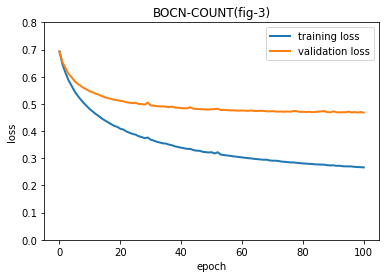

In [42]:
# plot the figure to check the training and validation loss during the training process

plot_loss_history(tra_loss_bocn_c, val_loss_bocn_c, "BOCN-COUNT(fig-3)")

### Analyze the loss-epoch figure for model of BOCN-COUNT 

From figure 3, we could know the model for BOCN-COUNT is trained well.

1. Because the final validation loss is low enough (about 0.46) and the validation loss tends to be flat from declining at the end of training, the model is not underfitted.

2. The difference between the final training loss and the final validation loss is small (about 0.2) and the validation loss doesn't have the overall tendency to rise. Therefore, the model is not overfitted.

In [43]:
# compute the accuracy, precision, recall, and f1_score to evaluate the model under BOCN-count situation

preds_bocn_c = predict_class(test_count_mat_bocn, weights_bocn_c)

print('Accuracy:', accuracy_score(test_label, preds_bocn_c))
print('Precision:', precision_score(test_label, preds_bocn_c))
print('Recall:', recall_score(test_label, preds_bocn_c))
print('F1-Score:', f1_score(test_label, preds_bocn_c))

Accuracy: 0.82
Precision: 0.8232323232323232
Recall: 0.815
F1-Score: 0.8190954773869347


In [44]:
# print top 10 words for negative class and positive class respectively.

top_neg_bocn_c = weights_bocn_c.reshape(1, -1).argsort()[0][:10]
for i in top_neg_bocn_c:
    print(id2word_bocn[i])

bad
ors
esa
wors
tal
nly
was
only
hen
plo


In [45]:
top_pos_bocn_c = weights_bocn_c.reshape(1, -1).argsort()[0][::-1][:10]
for i in top_pos_bocn_c:
    print(id2word_bocn[i])

ese
gre
ral
erf
tru
grea
lar
ood
eca
great


### Analyze the top-10 words for model of BOCN-COUNT

The top-10 character combinations of model for BOCN-COUNT make sense for sentiment classification task.

For example, "wors", "ors" is part of the word "worst", and "bad" is equal to the word "bad". Then, "gre", "grea" is part of the word "great", and "erf" is part of the word "perfect". These words could be used to describe a movie.

Then, I think these character combinations are generalized well in other domain like restaurant review. Because it is reasonable to say "this is the worst food I have ever eaten" and "this is a great meal".

For a restraurant review domain, the classifier may pick up character combinations like "delic"(part of delicious), "tast"(part of "tasty")...


### Discuss how I choose hyperparameters for model of BOCN-COUNT

1. I choose the hyperparameters (learning rate, alpha, epoch, tolerance) by testing the development(validation) dataset on several different set of hyperparameters. The set of hyperparameters which could help the model to achieve the highest validation accuracy and lowest validation loss are the best hyperparameters. I will randomly display several set of hyperparameters and the corresponding validation loss and validation accuracy.

| lr | alpha |epoch  | tolerance | val_loss | val_accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 0.000010  | 0.500000 | 100  |  0.000010 | 0.468004 | 0.790000  |
| 0.000010  |  0.300000| 100  |  0.000010  | 0.473518 | 0.780000  |
| 0.000010  | 0.500000   |30  | 0.000010 | 0.493779  | 0.785000 |
| 0.000001 | 0.500000  |  100  | 0.000010  | 0.546285  | 0.760000 |
| 0.000010  | 0.500000   |  100 | 0  |0.469430  | 0.765000 |

From the above table, we could find when the lr = 1e-5, alpha = 0.5, epoch = 100, tolerance = 1e-5, the validation loss is lowest (0.468) and the validation accuracy is highest (0.79). Therefore, I choose this set of hyperparameters as my best hyperparameters for model of BOCN-COUNT.

# Model 4: BOCN-TFIDF

## Training and evaluate for BOCN-tfidf

## The hyperparameters tuning part for the model of BOCN-TFIDF

Please don't count the running time of this part.

In [46]:
# choose the best hyperparameters for BOCN-tfidf

best_parameter_bocn_tfidf = choose_hyper(train_tfidf_mat_bocn, train_label, dev_tfidf_mat_bocn, dev_label, 
                              lr_candidate = [1e-5, 1e-6], alpha_candidate = [5*1e-1, 1e-1], 
                              epoch_candidate = [100, 300], tolerance_candidate = [1e-4, 1e-5])

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.558239, val_acc = 0.775000

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000010, val_loss = 0.558246, val_acc = 0.775000

lr = 0.000010, alpha = 0.500000, epoch = 300, tolerance = 0.000100, val_loss = 0.543069, val_acc = 0.780000

lr = 0.000010, alpha = 0.500000, epoch = 300, tolerance = 0.000010, val_loss = 0.536460, val_acc = 0.775000

lr = 0.000010, alpha = 0.100000, epoch = 100, tolerance = 0.000100, val_loss = 0.536973, val_acc = 0.780000

lr = 0.000010, alpha = 0.100000, epoch = 100, tolerance = 0.000010, val_loss = 0.536955, val_acc = 0.785000

lr = 0.000010, alpha = 0.100000, epoch = 300, tolerance = 0.000100, val_loss = 0.503381, val_acc = 0.770000

lr = 0.000010, alpha = 0.100000, epoch = 300, tolerance = 0.000010, val_loss = 0.489931, val_acc = 0.765000

lr = 0.000001, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.656220, val_acc = 0.655000

lr = 0.000001, alph

End of the hyperparameters tuning process.

## Train the model of BOCN-TFIDF by using the best hyperparameters.

In [47]:
# Under BOCN-TFIDF situation, training the model by using the best parameters
weights_bocn_tfidf, tra_loss_bocn_tfidf, val_loss_bocn_tfidf = SGD(train_tfidf_mat_bocn, train_label, 
                                                                   dev_tfidf_mat_bocn, dev_label, 
                                                                   lr = best_parameter_bocn_tfidf[0], 
                                                                   alpha = best_parameter_bocn_tfidf[1],
                                                                   epochs = best_parameter_bocn_tfidf[2],
                                                                   tolerance = best_parameter_bocn_tfidf[3], 
                                                                   print_progress = True)

epoch   0: training loss is 0.685852, validation loss is 0.687071.
epoch   1: training loss is 0.679900, validation loss is 0.682709.
epoch   2: training loss is 0.674313, validation loss is 0.678848.
epoch   3: training loss is 0.668899, validation loss is 0.675120.
epoch   4: training loss is 0.663651, validation loss is 0.671512.
epoch   5: training loss is 0.658564, validation loss is 0.668081.
epoch   6: training loss is 0.653614, validation loss is 0.664702.
epoch   7: training loss is 0.648803, validation loss is 0.661434.
epoch   8: training loss is 0.644118, validation loss is 0.658320.
epoch   9: training loss is 0.639563, validation loss is 0.655235.
epoch  10: training loss is 0.635116, validation loss is 0.652299.
epoch  11: training loss is 0.630786, validation loss is 0.649474.
epoch  12: training loss is 0.626570, validation loss is 0.646689.
epoch  13: training loss is 0.622453, validation loss is 0.643919.
epoch  14: training loss is 0.618443, validation loss is 0.641

epoch 123: training loss is 0.424307, validation loss is 0.525084.
epoch 124: training loss is 0.423450, validation loss is 0.524596.
epoch 125: training loss is 0.422593, validation loss is 0.524183.
epoch 126: training loss is 0.421742, validation loss is 0.523859.
epoch 127: training loss is 0.420900, validation loss is 0.523426.
epoch 128: training loss is 0.420068, validation loss is 0.522951.
epoch 129: training loss is 0.419239, validation loss is 0.522566.
epoch 130: training loss is 0.418419, validation loss is 0.522171.
epoch 131: training loss is 0.417605, validation loss is 0.521789.
epoch 132: training loss is 0.416798, validation loss is 0.521381.
epoch 133: training loss is 0.415997, validation loss is 0.521031.
epoch 134: training loss is 0.415204, validation loss is 0.520658.
epoch 135: training loss is 0.414416, validation loss is 0.520246.
epoch 136: training loss is 0.413635, validation loss is 0.519879.
epoch 137: training loss is 0.412860, validation loss is 0.519

epoch 246: training loss is 0.353682, validation loss is 0.494014.
epoch 247: training loss is 0.353299, validation loss is 0.493857.
epoch 248: training loss is 0.352917, validation loss is 0.493732.
epoch 249: training loss is 0.352539, validation loss is 0.493655.
epoch 250: training loss is 0.352163, validation loss is 0.493374.
epoch 251: training loss is 0.351788, validation loss is 0.493244.
epoch 252: training loss is 0.351413, validation loss is 0.493162.
epoch 253: training loss is 0.351042, validation loss is 0.493088.
epoch 254: training loss is 0.350672, validation loss is 0.492946.
epoch 255: training loss is 0.350305, validation loss is 0.492741.
epoch 256: training loss is 0.349939, validation loss is 0.492647.
epoch 257: training loss is 0.349575, validation loss is 0.492482.
epoch 258: training loss is 0.349214, validation loss is 0.492355.
epoch 259: training loss is 0.348854, validation loss is 0.492232.
epoch 260: training loss is 0.348497, validation loss is 0.492

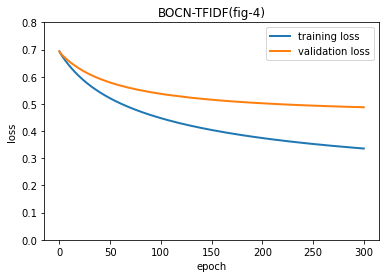

In [48]:
# plot the figure to check the training and validation loss during the training process

plot_loss_history(tra_loss_bocn_tfidf, val_loss_bocn_tfidf, "BOCN-TFIDF(fig-4)")

### Analyze the loss-epoch figure for model of BOCN-TFIDF

In figure 4, we could know, the model for BOCN-TFIDF is trained well.

1. Because the validation loss line is becoming flat from declining and the final value of validation loss is low (about 0.47), the model is not underfitted.

2. The difference between the final training loss and the final validation loss is small (about 0.17) and the validation loss line doen't have the tendency to rise. So the model isn't overfitted.


In [49]:
# compute the accuracy, precision, recall, and f1_score to evaluate the model under BOCN-TFIDF situation

preds_bocn_tfidf = predict_class(test_tfidf_mat_bocn, weights_bocn_tfidf)

print('Accuracy:', accuracy_score(test_label, preds_bocn_tfidf))
print('Precision:', precision_score(test_label, preds_bocn_tfidf))
print('Recall:', recall_score(test_label, preds_bocn_tfidf))
print('F1-Score:', f1_score(test_label, preds_bocn_tfidf))

Accuracy: 0.8325
Precision: 0.8275862068965517
Recall: 0.84
F1-Score: 0.8337468982630273


In [50]:
# print top 10 words for negative class and positive class respectively.

top_neg_bocn_tfidf = weights_bocn_tfidf.reshape(1, -1).argsort()[0][:10]
for i in top_neg_bocn_tfidf:
    print(id2word_bocn[i])

bad
wors
was
orst
ppose
ppos
poo
adl
nothi
dio


In [51]:
top_pos_bocn_tfidf = weights_bocn_tfidf.reshape(1, -1).argsort()[0][::-1][:10]
for i in top_pos_bocn_tfidf:
    print(id2word_bocn[i])

grea
great
erful
rful
perfe
rfec
erfec
rfect
beau
ilar


### Analyze the top-10 words for model of BOCN-TFIDF

These character combinations ('bad', 'wors', 'orst', 'nothi', 'grea', 'great', 'perfe', 'rfec', 'erfec', rfect', 'beau', and 'ilar') make sense for classification. For example, 'wors', 'orst' are part of 'worst'; 'grea', 'great' are part of 'great'; 'perfe', 'rfec', 'erfec', 'rfect' are part of 'perfect'.

Meanwhile, I think these aforementioned character combinations are generalized for the classification task in other domain. Because they are part of those words which could be used to describe all kinds of merchandises. For instance, you could always say "this is a perfect food/phone/book(any kind of products)" and also, you could always say "this is the worst movies/clothes/car(any kind of products) I've ever seen"

There are also some other character combinations could be used to the classification task in new domain. Such as "brill(part of brilliant)", "awf(part of awful)", "favor(part of favorite)".

### Discuss how I choose hyperparameters for model of BOCN-TFIDF

1. I choose the hyperparameters (learning rate, alpha, epoch, tolerance) by testing the development(validation) dataset on several different set of hyperparameters. The set of hyperparameters which could help the model to achieve the highest validation accuracy and lowest validation loss are the best hyperparameters. I will randomly display several set of hyperparameters and the corresponding validation loss and validation accuracy.

| lr | alpha |epoch  | tolerance | val_loss | val_accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 0.000010  | 0.100000 | 300  |  0.000100 | 0.503381  | 0.770000 |
| 0.000010  |  0.500000| 300  |  0.000100  | 0.543069 | 0.780000 |
| 0.000010  | 0.100000   |100  | 0.000100 | 0.536973 |0.780000 |
| 0.000001 | 0.100000  |  300  | 0.000100  | 0.608475  | 0.735000  |
| 0.000010  | 0.100000   |  300 | 0.000010  |0.489931 |0.765000 |

From the above table, we could find when the lr = 1e-5, alpha = 0.1, epoch = 300, tolerance = 1e-5, the validation loss is lowest (0.4899). Therefore, I choose this set of hyperparameters as my best hyperparameters for model of BOCN-TFIDF.

# Model 5: BOW+BOCN(TFIDF)

## Training and evaluate BOW + BOCN (TFIDF)

Create vocabulary and vectorized feature matrices for BOW + BOCN.

In [52]:
#     combine the vocabulary for BOW and the vocabulary for BOCN, if there are words appearing in both vocab_bow and 
# vocab_bocn, these words are only counted one time in vocabulary for BOW+BOCN.

vocab_bb = set.union(vocab_bow, vocab_bocn)


#    create a dictionary to store the terms' document frequencies for BOW+BOCN 
df_bb = df_bow.copy()

for term in df_bocn:
    if term not in df_bow:
        df_bb[term] = df_bocn[term]
    else:
        if df_bb[term] >= df_bocn[term]:
            continue
        else:
            df_bb[term] = df_bocn[term]


#     create 2 dictionaries: (1) id2word_bb: keys = vocabulary ids, values = words (2) word2id_bb: keys = words, 
# values = vocabulary ids for BOW+BOCN

id2word_bb = dict()
word2id_bb = dict()

for i in range(len(vocab_bb)):
    id2word_bb[i] = list(vocab_bb)[i]
    word2id_bb[list(vocab_bb)[i]] = i



#    Combine the two extracted features words lists of BOCN and BOW for BOW+BOCN mode.

train_extracted_ngrams_bb = []
for i in range(1400):
    train_extracted_ngrams_bb.append(train_extracted_ngrams.copy()[i] + train_extracted_ngrams_bocn.copy()[i])

dev_extracted_ngrams_bb = []
for i in range(200):
    dev_extracted_ngrams_bb.append(dev_extracted_ngrams.copy()[i] + dev_extracted_ngrams_bocn.copy()[i])
    
test_extracted_ngrams_bb = []
for i in range(400):
    test_extracted_ngrams_bb.append(test_extracted_ngrams.copy()[i] + test_extracted_ngrams_bocn.copy()[i])


#    vectorize the combined extracted features words for BOW+BOCN mode

train_count_mat_bb = vectorise(train_extracted_ngrams_bb, vocab_bb, word2id_bb)
dev_count_mat_bb = vectorise(dev_extracted_ngrams_bb, vocab_bb, word2id_bb)
test_count_mat_bb = vectorise(test_extracted_ngrams_bb, vocab_bb, word2id_bb)


#    obtain the tfidf features for BOW+BOCN mode

# compute the inverted document frequencies values for words in vocab_bb
idfs_bb = np.zeros((1, len(vocab_bb)))
for i in range(len(vocab_bb)):
    idfs_bb[0, i] = np.log10(len(train_text)/df_bb[list(vocab_bb)[i]])

# transform the count vectors to tf.idf vectors

train_tfidf_mat_bb = train_count_mat_bb * idfs_bb
dev_tfidf_mat_bb = dev_count_mat_bb * idfs_bb
test_tfidf_mat_bb = test_count_mat_bb * idfs_bb



## Hyperparameters tunning for the model of BOW+BOCN-TFIDF

Please don't count the running time of this part.

In [53]:
# choose the best hyperparameters for BOW+BOCN-TFIDF

best_parameter_bb_tfidf = choose_hyper(train_tfidf_mat_bb, train_label, dev_tfidf_mat_bb, dev_label, 
                              lr_candidate = [1e-5, 1e-6], alpha_candidate = [5*1e-1, 1e-1], 
                              epoch_candidate = [100, 300], tolerance_candidate = [1e-4, 1e-5])

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.499285, val_acc = 0.800000

lr = 0.000010, alpha = 0.500000, epoch = 100, tolerance = 0.000010, val_loss = 0.499253, val_acc = 0.800000

lr = 0.000010, alpha = 0.500000, epoch = 300, tolerance = 0.000100, val_loss = 0.482736, val_acc = 0.815000

lr = 0.000010, alpha = 0.500000, epoch = 300, tolerance = 0.000010, val_loss = 0.476746, val_acc = 0.815000

lr = 0.000010, alpha = 0.100000, epoch = 100, tolerance = 0.000100, val_loss = 0.473798, val_acc = 0.810000

lr = 0.000010, alpha = 0.100000, epoch = 100, tolerance = 0.000010, val_loss = 0.473762, val_acc = 0.805000

lr = 0.000010, alpha = 0.100000, epoch = 300, tolerance = 0.000100, val_loss = 0.426583, val_acc = 0.830000

lr = 0.000010, alpha = 0.100000, epoch = 300, tolerance = 0.000010, val_loss = 0.422459, val_acc = 0.835000

lr = 0.000001, alpha = 0.500000, epoch = 100, tolerance = 0.000100, val_loss = 0.627164, val_acc = 0.750000

lr = 0.000001, alph

End of the hyperparameters tunning.

## Train the model for BOW+BOCN-TFIDF by using the chosen hyperparameters.

In [54]:
# Under BOW+BOCN-TFIDF situation, training the model by using the best parameters
weights_bb_tfidf, tra_loss_bb_tfidf, val_loss_bb_tfidf = SGD(train_tfidf_mat_bb, train_label, 
                                                             dev_tfidf_mat_bb, dev_label, 
                                                             lr = best_parameter_bb_tfidf[0], 
                                                             alpha = best_parameter_bb_tfidf[1],
                                                             epochs = best_parameter_bb_tfidf[2],
                                                             tolerance = best_parameter_bb_tfidf[3], 
                                                             print_progress = True)

epoch   0: training loss is 0.677986, validation loss is 0.682771.
epoch   1: training loss is 0.664918, validation loss is 0.674573.
epoch   2: training loss is 0.652740, validation loss is 0.667154.
epoch   3: training loss is 0.641209, validation loss is 0.660362.
epoch   4: training loss is 0.630339, validation loss is 0.653612.
epoch   5: training loss is 0.619945, validation loss is 0.647576.
epoch   6: training loss is 0.610114, validation loss is 0.641618.
epoch   7: training loss is 0.600799, validation loss is 0.636198.
epoch   8: training loss is 0.591912, validation loss is 0.630902.
epoch   9: training loss is 0.583342, validation loss is 0.625526.
epoch  10: training loss is 0.575220, validation loss is 0.620630.
epoch  11: training loss is 0.567518, validation loss is 0.615830.
epoch  12: training loss is 0.560103, validation loss is 0.611365.
epoch  13: training loss is 0.552899, validation loss is 0.607137.
epoch  14: training loss is 0.546020, validation loss is 0.603

epoch 123: training loss is 0.289342, validation loss is 0.461106.
epoch 124: training loss is 0.288408, validation loss is 0.460591.
epoch 125: training loss is 0.287486, validation loss is 0.460126.
epoch 126: training loss is 0.286574, validation loss is 0.459716.
epoch 127: training loss is 0.285676, validation loss is 0.459335.
epoch 128: training loss is 0.284777, validation loss is 0.458852.
epoch 129: training loss is 0.283890, validation loss is 0.458381.
epoch 130: training loss is 0.283015, validation loss is 0.458011.
epoch 131: training loss is 0.282148, validation loss is 0.457614.
epoch 132: training loss is 0.281287, validation loss is 0.457185.
epoch 133: training loss is 0.280434, validation loss is 0.456756.
epoch 134: training loss is 0.279590, validation loss is 0.456339.
epoch 135: training loss is 0.278754, validation loss is 0.455925.
epoch 136: training loss is 0.277926, validation loss is 0.455519.
epoch 137: training loss is 0.277106, validation loss is 0.455

epoch 246: training loss is 0.218119, validation loss is 0.428862.
epoch 247: training loss is 0.217762, validation loss is 0.428730.
epoch 248: training loss is 0.217407, validation loss is 0.428601.
epoch 249: training loss is 0.217054, validation loss is 0.428403.
epoch 250: training loss is 0.216704, validation loss is 0.428252.
epoch 251: training loss is 0.216354, validation loss is 0.428157.
epoch 252: training loss is 0.216008, validation loss is 0.428028.
epoch 253: training loss is 0.215664, validation loss is 0.427920.
epoch 254: training loss is 0.215322, validation loss is 0.427800.
epoch 255: training loss is 0.214981, validation loss is 0.427642.
epoch 256: training loss is 0.214643, validation loss is 0.427489.
epoch 257: training loss is 0.214307, validation loss is 0.427328.
epoch 258: training loss is 0.213973, validation loss is 0.427191.
epoch 259: training loss is 0.213642, validation loss is 0.427106.
epoch 260: training loss is 0.213311, validation loss is 0.426

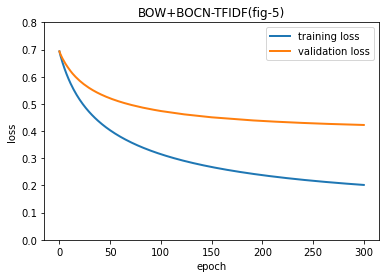

In [55]:
# plot the figure to check the training and validation loss during the training process

plot_loss_history(tra_loss_bb_tfidf, val_loss_bb_tfidf, "BOW+BOCN-TFIDF(fig-5)")

### Analyze the loss-epoch figure for model of BOW+BOCN-TFIDF

From figure 5, we could find the model for BOW+BOCN-TFIDF is trained well.

1. The final test accuracy is high enough (86%), the final validation loss is low enough(about 0.42), and the validation loss line begin to be flat from declining. So the model is not underfitted.

2. The difference between the final training loss and the final validation loss is small (about 0.22), and the validation loss line doesn't have tendency to rise at the end of model training. Therefore the model is not overfitted.

In [56]:
# compute the accuracy, precision, recall, and f1_score to evaluate the model under BOCN-TFIDF situation

preds_bb_tfidf = predict_class(test_tfidf_mat_bb, weights_bb_tfidf)

print('Accuracy:', accuracy_score(test_label, preds_bb_tfidf))
print('Precision:', precision_score(test_label, preds_bb_tfidf))
print('Recall:', recall_score(test_label, preds_bb_tfidf))
print('F1-Score:', f1_score(test_label, preds_bb_tfidf))

Accuracy: 0.86
Precision: 0.8461538461538461
Recall: 0.88
F1-Score: 0.8627450980392156


In [57]:
# print top 10 words for negative class and positive class respectively.

top_neg_bb_tfidf = weights_bb_tfidf.reshape(1, -1).argsort()[0][:10]
for i in top_neg_bb_tfidf:
    print(id2word_bb[i])

bad
worst
waste
poor
dull
awful
lame
fails
plot
looks


In [58]:
top_pos_bb_tfidf = weights_bb_tfidf.reshape(1, -1).argsort()[0][::-1][:10]
for i in top_pos_bb_tfidf:
    print(id2word_bb[i])


great
pulp
quite
true
beau
life
seen
world
damon
rush


### Analyze the top-10 words for model of BOW+BOCN-TFIDF

The top-10 words and character combinations of the model for BOW+BOCN-TFIDF make sense for the sentimental classification task.

We could easily find the words "bad", "worst", "poor", "dull", "awful" could be used to describe movies with a negative emotion. Then the words "great", "beau", could be used to describe movies with positive emotion.

Besides, these words are generalized well for other domain.

### Discuss how I choose hyperparameters for model of BOW+BOCN-TFIDF

1. I choose the hyperparameters (learning rate, alpha, epoch, tolerance) by testing the development(validation) dataset on several different set of hyperparameters. The set of hyperparameters which could help the model to achieve the highest validation accuracy and lowest validation loss are the best hyperparameters. I will randomly display several set of hyperparameters and the corresponding validation loss and validation accuracy.

| lr | alpha |epoch  | tolerance | val_loss | val_accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 0.000010  | 0.100000 | 300  |  0.000100 | 0.426583  | 0.830000 |
| 0.000010  |  0.500000| 300  |  0.000100  | 0.482736 | 0.815000 |
| 0.000010  | 0.100000   |100  | 0.000100 | 0.473798 |0.810000 |
| 0.000001 | 0.100000  |  300  | 0.000100  | 0.557198  | 0.765000 |
| 0.000010  | 0.100000   |  300 | 0.000010  |0.422459 |0.835000 |

When lr = 1e-5, alpha = 0.1, epoch = 300, tolerance = 1e-5, the model could have the lowest validation loss. So this set of hyperparameters is my best hyperparameters for model of BOW+BOCN-TIFDF




# Full Results

Add here your results:

| LR | Accuracy |Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|:-:|
| BOW-count  |  0.8225 | 0.8057  |  0.85 | 0.8273  |
| BOW-tfidf  |  0.865 | 0.851  | 0.885  |  0.8676 |
| BOCN-count  | 0.82  | 0.8232  | 0.815  | 0.8191  |
| BOCN-tfidf  | 0.8325  |  0.8276 | 0.84  | 0.8337  |
| BOW+BOCN-tfidf  | 0.86  |  0.8462 | 0.88  | 0.8627  |

Please discuss why your best performing model is better than the rest.

From the above table, we could find my best model is the model for BOW-tfidf. The model for BOW-tfidf has a 0.8676 F1-score. Then, the BOW+BOCN-tfidf model's F1-score (0.8627) is slightly lower than BOW-tfidf's. 

First, I think the reason for why BOW-tfidf model is better than BOW-count model is that BOW-tfidf uses tfidf weighted feature values. Compared with raw-frequency weighted feature values, tfidf will help model classify which words are more informative. 

For example, if I input a sentence "Sheffield is a beautiful city" to a raw-frequency based model, the model will treat all five words in this sentence equally. It means, for the model, the word "a" contains same information with the word "beautiful". In fact, it is obvious for human that the word "beautiful" contains more information than "a" and "is" to help us know this sentence is a positive comment. Usually, this kind of words with low information such as "a", "the", "is" would appear lots of times in the whole document collection. It means the informativeness is inveresly related to document frequency(df). The less common words (low df value) are usually more informative. Therefore, we could use tfidf weighted method to give those words with low information a low weight and give those words with high information a high weight.

By using TFIDF weighted method, the words with low document frequencies but with high information could influence more in the text classification task. Therefore, the BOW-tfidf has a better performance than BOW-count.

Second, compared with BOCN models, the BOW has a better performance. I think the reason might be the BOCN model splits the key words for classification and because the capacity of vocab_bocn(vocabulary for BOCN) is limited, the vocab_bocn contains less key words than vocab_bow(vocabulary for BOW). For example, we could see from the top-10 positive words of BOCN-tfidf model, one key word "great" is splited to "gre", "grea", "great", and one key word "perfectly" is splited to "perf" "rfect", "erfec". In this way, if vocab_bow contains 4000 different key words, the vocab_bocn could only contain 4000 character combinations from 1000 different key words. I think this will lead the vocab_bocn to be low informative. So the BOW has better performance than BOCN.

# Discussion about the choices of text processing and hyperparameters values.

1. About the choices of text processing, I have commented in the coding. Let me do a summary here.

1.1 First, to process the original text in documents, I tried to make all letters in text be lowercase (but I found this task had been done). Then, I removed all numbers and punctuations from the texts because these characters are not useful for sentimental classification. 

After this, I find all words with two or more than two letters. It means the simple words such as "a", "I" are dropped. Then, based on the flag char_ngrams, my extract_ngrams function could extract words or character combinations for each document in document collection.

1.2 Then, I adjusted the stoplist. I added 'am', 'll', 'also', 'why', 'would', 'should', 'their', 'might', 'there', 'where', 'him' to the original stoplist because I think these words have a high term frequencies in the whole collection but with low information to help the model do classification.

1.3 Thirdly, about the vocabulary size, it should be splited to two part. The first one is vocab_bow (vocabulary for the model of BOW) and the second one is vocab_bocn (vocabulary for the model of BOCN). For the vocab_bow, I only picked those words with a document frequency higher than 20. At this time, the vocabulary size of vocab_bow is 4488. For the vocab_bocn, I set the keep_topN = 4000. It means to pick top 4000 of term frequency in collection of character combinations and therefore, the size of vocab_bocn is 4000. Then, in the training process, I found the vocabulary with size of 4000 provided enough information for model training. All the models are trained well with 83% test accuracy in average and the training time is fast. Therefore, I think 4000 is a proper vocabulary size. 

1.4 Then, about the ngram_range, I choose to (1, 3) for BOW model and (3, 5) for BOCN model. The reason for why I choose (3, 5) as ngram_range for BOCN model is:

If the ngram_range value is too small, the character combinations will be too short. At this time, different words could produce the same character combinations. For example, a negative word "worst" contain character combinations "wo", but a positive word "wonderful" could also contain a character combinations "wo". So, if the ngram_range value is too small, the short character combinations would be confusing.

Similarly, if ngram_range is too large, the character combinations would be too long. At that time, a long character combination might only appear in one document. It will be also bad for model training.


2. About the choices of hyperparameters.

For all five models, I choose to use a low learning rate and a relatively high epoch number. Because I found when I use a high learning rate, although it could complete the training in a few epochs, the validation loss could not decline stablely (the validation loss may decline in this epoch and then, rise in next epoch, the validation loss line is fluctuant). So, I decided to use a small learning rate such as 1e-5 and a high epoch like 300. With this small learning rate and high epoch, the validation loss of my models could decline stablely and the trained model could trained well with a low validation loss.

For the regularization hyperparameter alpha, I set it from 0.1 - 0.5. Because when I set it small such as 0.01 or 0.001, I found my model is often overfitted. The final training loss will be very small (lower than 0.1) but the validation loss is still higher than 0.3. Therefore, I set a relatively high alpha to avoid my models being overtrained.
